# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

This time we use the **PPO** (Proximal Policy Optimization) algorithm!

In [ ]:
#restart the kernel once after install this package
#!pip install 'gym<0.25.0'
#!pip install 'gym[atari, accept-rom-license]'

In [2]:
# Watch for changes
%load_ext autoreload
%autoreload 2

# custom utilies for displaying animation, collecting rollouts and more
import numpy as np
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

# Monkey patch missing attributes for newer numpy versions
if not hasattr(np, "float_"):
    np.float_ = np.float64
    
if not hasattr(np, "int_"):
    np.int_ = np.int64

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

using device:  cuda:0


In [3]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



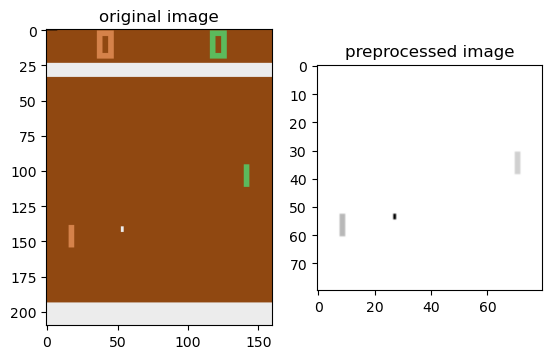

In [4]:
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _,_ , _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()


# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        # Assume the preprocessed Pong input is an 80x80 image with 2 channels (e.g., frame difference or stacked frames)
        # Conv layer 1: 2 input channels → 16 filters; kernel size=8, stride=4.
        # Output size: ((80-8)//4 + 1) = 19, so output: 16 x 19 x 19.
        self.conv1 = nn.Conv2d(2, 16, kernel_size=8, stride=4)
        
        # Conv layer 2: 16 → 32 filters; kernel size=4, stride=2.
        # Output size: ((19-4)//2 + 1) = 8, so output: 32 x 8 x 8.
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        
        # Conv layer 3: 32 → 64 filters; kernel size=3, stride=1.
        # Output size: ((8-3)//1 + 1) = 6, so output: 64 x 6 x 6.
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        
        # Flattened size = 64 * 6 * 6 = 2304.
        self.fc1 = nn.Linear(64 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Pass input through conv layers with ReLU activations.
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Flatten the tensor for the fully connected layers.
        x = x.view(x.size(0), -1)
        
        # Pass through a fully connected layer.
        x = F.relu(self.fc1(x))
        # Output a single probability (for moving right).
        out = self.sigmoid(self.fc2(x))
        return out

policy=Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

In [6]:
pong_utils.play(env, policy, time=100)# , preprocess=pong_utils.preprocess_single) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [ ]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

Process Process-2:
Process Process-4:
Process Process-3:
Process Process-1:
Traceback (most recent call last):
  File "/home/oliver/anaconda3/envs/pytorch_env/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/oliver/anaconda3/envs/pytorch_env/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/oliver/project-showroom/concepts/reinforcement-learning/policy-gradient-ascent/parallelEnv.py", line 104, in worker
    cmd, data = remote.recv()
  File "/home/oliver/anaconda3/envs/pytorch_env/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/oliver/anaconda3/envs/pytorch_env/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/oliver/anaconda3/envs/pytorch_env/lib/python3.10/multiprocessi

In [8]:
print(prob)

[array([0.49985403, 0.5001674 , 0.50015616, 0.5001454 ], dtype=float32), array([0.4998473 , 0.4998414 , 0.50013745, 0.5001454 ], dtype=float32), array([0.4998014 , 0.5002025 , 0.50021076, 0.5001867 ], dtype=float32), array([0.5001572, 0.4998511, 0.4998501, 0.4998572], dtype=float32), array([0.49977624, 0.4997812 , 0.4997812 , 0.49979442], dtype=float32), array([0.49984032, 0.5001687 , 0.5001687 , 0.49983692], dtype=float32), array([0.5001698 , 0.49980593, 0.49980593, 0.5001674 ], dtype=float32), array([0.4998381 , 0.49981207, 0.50018793, 0.50019276], dtype=float32), array([0.4998678 , 0.49986023, 0.49983197, 0.5001511 ], dtype=float32), array([0.50013775, 0.49986225, 0.50014776, 0.500138  ], dtype=float32), array([0.50013345, 0.5001314 , 0.500143  , 0.49987847], dtype=float32), array([0.49986303, 0.4998241 , 0.49984264, 0.49985415], dtype=float32), array([0.50014   , 0.5001624 , 0.50016004, 0.5001598 ], dtype=float32), array([0.5000043 , 0.49994648, 0.50003093, 0.5000238 ], dtype=float

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

Ok, let us use this in our surrogate function, which approximates the reward estimation so that we have a signal for the gradient ascent step.

In [13]:
def surrogate_ppo(policy, old_probs, states, actions, rewards,
                  discount=0.995, beta=0.01, epsilon=0.2):
    """
    Compute the PPO surrogate loss.
    
    Parameters:
      policy: the current policy (neural network)
      old_probs: list or array of probabilities for the taken actions under the old policy
      states: list/array of states encountered in the trajectory
      actions: list/array of actions taken
      rewards: list/array of rewards received
      discount: discount factor for future rewards (default: 0.995)
      beta: entropy bonus coefficient (default: 0.01)
      epsilon: clipping parameter for importance sampling (default: 0.2)
    
    Returns:
      total_loss: the PPO surrogate loss (to be minimized)
    """
    # Convert old_probs to a torch tensor so we can perform element-wise operations.
    old_probs = torch.tensor(old_probs, dtype=torch.float32, device=device)
    
    # Convert actions to a tensor (ensure appropriate type and device)
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    
    # Compute new policy probabilities from states.
    # This function should convert states into the proper input shape for the policy.
    new_probs = pong_utils.states_to_prob(policy, states)

    # Choose the probability corresponding to the taken action:
    # If the action equals pong_utils.RIGHT, use new_probs; otherwise, use 1-new_probs.
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0 - new_probs)
    
    # Compute the importance sampling ratio:
    # This is the ratio between the new probability and the old probability of the taken action.
    ratio = new_probs / (old_probs + 1e-10)
    
    # Compute discounted cumulative rewards (returns)
    discounted_rewards = []
    R = 0
    for r in reversed(rewards):
        R = r + discount * R
        discounted_rewards.insert(0, R)
        
    discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32, device=device)
    
    # Normalize discounted rewards to reduce variance.
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-10)

    # PPO surrogate objective: use clipping to prevent excessive policy updates.
    surrogate_term = torch.min(
        ratio * discounted_rewards,
        torch.clamp(ratio, 1.0 - epsilon, 1.0 + epsilon) * discounted_rewards
    )
    
    # The policy loss is the negative mean of the surrogate term.
    policy_loss = -torch.mean(surrogate_term)
    
    # Compute the entropy of the new policy (for a Bernoulli distribution)
    entropy = -(
        new_probs * torch.log(new_probs + 1e-10) +
        (1.0 - new_probs) * torch.log(1.0 - new_probs + 1e-10)
    )
    entropy_reg = beta * torch.mean(entropy)
    
    # Total loss: subtract the entropy bonus (since higher entropy is desirable)
    total_loss = policy_loss - entropy_reg
    return total_loss


# Example usage:
Lsur = surrogate_ppo(policy, prob, state, action, reward)
print(Lsur)


tensor(0.3561, device='cuda:0', grad_fn=<SubBackward0>)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [ ]:
from parallelEnv import parallelEnv
import numpy as np
import progressbar as pb
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 500

# widget bar to display progress

widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]

timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)

    # gradient ascent step
    for _ in range(SGD_epoch):
        L = -surrogate_ppo(policy, old_probs, states, actions, rewards,
                                          epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

Training is unstable here. Score increases slightly but decreases soon after. May be a better surrogate function could yield better results. Let's try this later in a another notebook with more advanced REINFORCE implementations (PPO).

In [11]:
# play game after training!
pong_utils.play(env, policy, time=2000) 

In [ ]:
plt.plot(mean_rewards)

In [ ]:
# save your policy!
torch.save(policy, 'REINFORCE.policy')

# load your policy if needed
# policy = torch.load('REINFORCE.policy')

# try and test out the solution!
# policy = torch.load('PPO_solution.policy')